In [78]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')
import base64
import io
from scipy.misc import imread
import codecs
from IPython.display import HTML

movies = pd.read_csv('../dataset/tmdb_5000_movies.csv')
credits = pd.read_csv('../dataset/tmdb_5000_credits.csv')

#movies.head(3)
#credits.head(3)

# Possible features: keywords, popularity, production_countries,
# revenue, vote_count


# Clean the dataset by converting json columns into list of strings
fields = ['genres', 'keywords', 'production_companies', 'production_countries']
for field in fields:
    movies[field]=movies[field].apply(json.loads)
    for index,i in zip(movies.index,movies[field]):
        list1=[]
        for j in range(len(i)):
            list1.append((i[j]['name']))
        movies.loc[index,field]=str(list1)
        
        
# Clean the credits 
credits['cast']=credits['cast'].apply(json.loads)
for index,i in zip(credits.index,credits['cast']):
    list1=[]
    for j in range(len(i)):
        list1.append((i[j]['name']))
    credits.loc[index,'cast']=str(list1)

fields = ['crew']
for field in fields:
    credits[field] = credits[field].apply(json.loads)
    def director(x):
        for i in x:
            if i['job'] == 'Director':
                return i['name']
    credits['crew'] = credits['crew'].apply(director)
    credits.rename(columns={'crew':'director'},inplace=True)

In [79]:
# Need to combine two datasets. Can join on movie_id
df = pd.merge(movies, credits, how='left', left_on='id', right_on='movie_id')

In [80]:
# Feature engineering! select which ones we want here...
features = ['id', 'original_title', 'genres', 'cast', 'vote_average', 'director', 'keywords', 'popularity', 'vote_count']
df = df[features]

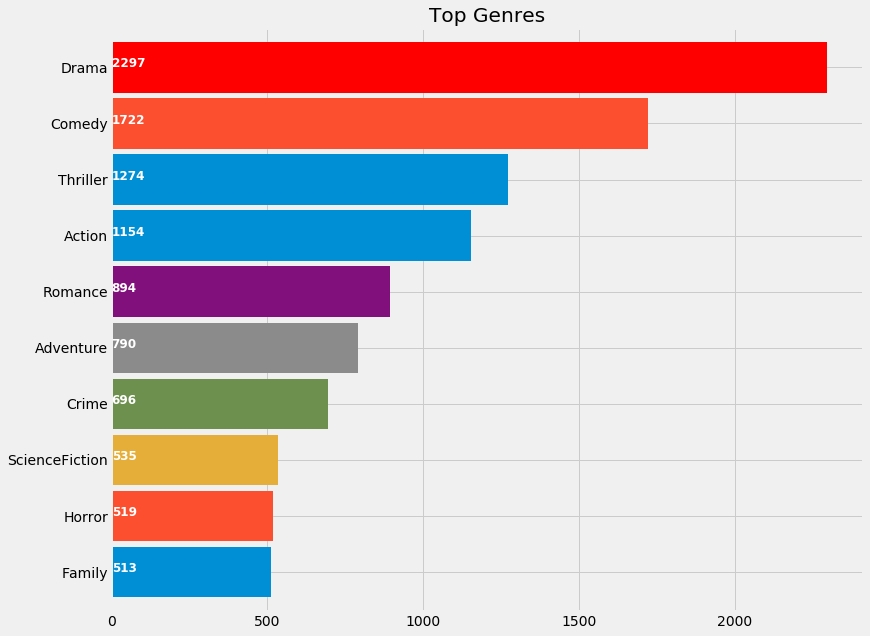

In [81]:
# Find top genres
df['genres'] = df['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('Adventure', 'Adv').str.replace('u', '').str.replace('Adv', 'Adventure')
df['genres'] = df['genres'].str.split(',')


plt.subplots(figsize=(12,10))
list1=[]
for i in df['genres']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9)
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
ax.patches[9].set_facecolor('r')
plt.title('Top Genres')
plt.show()

In [82]:
# Create an ordered list of all possible genres so we can use a bit string to represent them
genreList = []
for genres in df['genres']:
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)
            
genreList.sort()
genreList = genreList[1:]
print(genreList)

['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Docmentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Msic', 'Mystery', 'Romance', 'ScienceFiction', 'TVMovie', 'Thriller', 'War', 'Western']


In [83]:
# Create the bitstring of genres
def genre_bitlist(genres):
    blist = []
    for genre in genreList:
        if genre in genres:
            blist.append(1)
        else:
            blist.append(0)
    return blist

            
df['genres_bs'] = df['genres'].apply(lambda x: genre_bitlist(x))

In [84]:
# Work with cast. Let's get the top 25 actors
n = 25

df['cast']=df['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
df['cast']=df['cast'].str.split(',')


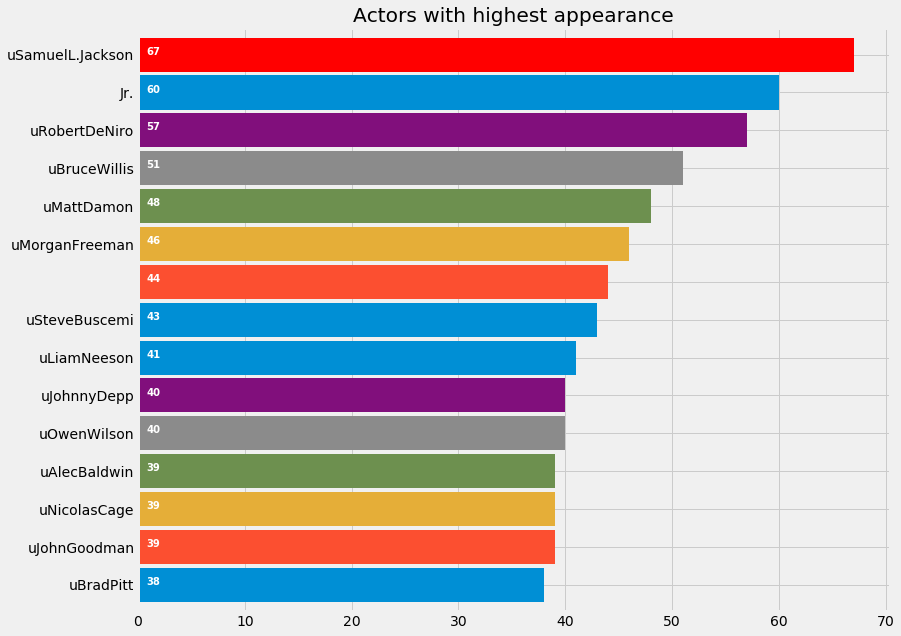

In [85]:
plt.subplots(figsize=(12,10))
list1=[]
for i in df['cast']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9)
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actors with highest appearance')
ax.patches[14].set_facecolor('r')
plt.show()

In [86]:
import operator 
actorList = []
list1 = []
for i in df['cast']:
    list1.extend(i)
    
actors = {}
for actor in list1:
    if actor in actors:
        actors[actor] += 1
    else:
        actors[actor] = 1
        
sorted_actors = sorted(actors.items(), key=operator.itemgetter(1))

for i in range(0, 21):
    actorList.append(sorted_actors[-1-i])
    

actorList = [actor[0] for actor in actorList]
alist = []
for actor in actorList:
    if actor != 'r.': # Get rid of this trailing value
        alist.append(actor)
actorList = alist

# Now we need to sort the list!
actorList = sorted(actorList)
actorList = actorList[1:]

In [87]:
# Create the bitstring of genres
def actor_bitlist(actors):
    blist = []
    for actor in actorList:
        if actor in actors:
            blist.append(1)
        else:
            blist.append(0)
    return blist

df['cast_bs'] = df['cast'].apply(lambda x: actor_bitlist(x))

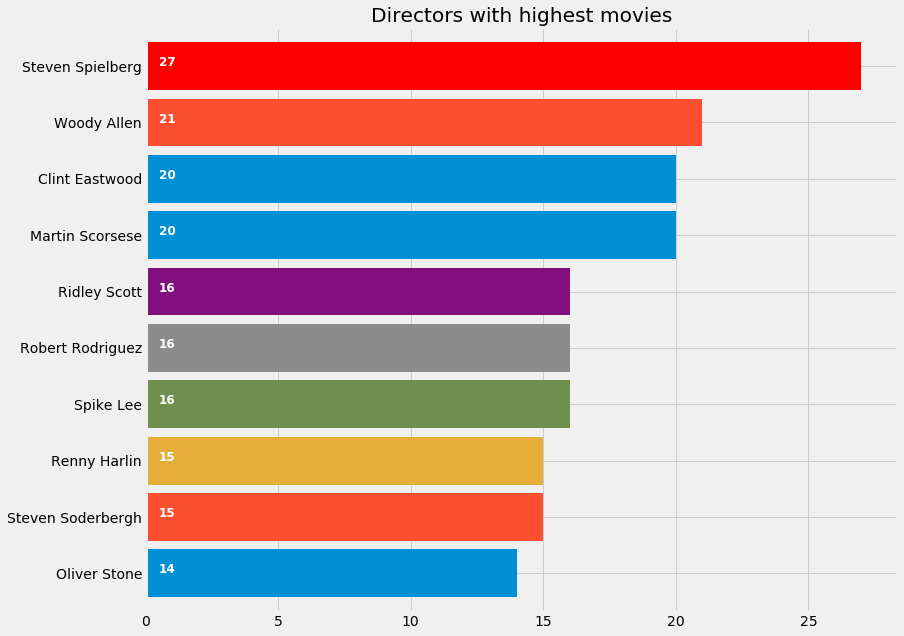

In [88]:
# Now directors
def isnull(s):
    if s is None:
        return ''
    return s

df['director'] = df['director'].apply(isnull)


plt.subplots(figsize=(12,10))
ax=df[df['director']!=''].director.value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.85)
for i, v in enumerate(df[df['director']!=''].director.value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
ax.patches[9].set_facecolor('r')
plt.title('Directors with highest movies')
plt.show()

In [89]:
directorList = []
for director in df['director']:
    if director not in directorList:
        directorList.append(director)
        
directorList = sorted(directorList)[1:]

In [90]:
def director_bitlist(directors):
    blist = []
    for director in directorList:
        if director in directors:
            blist.append(1)
        else:
            blist.append(0)
    return blist

df['director_bs'] = df['director'].apply(lambda x: director_bitlist(x))

In [91]:
# Allows us to make each genre a category in the dataframe
from collections import defaultdict
cols = defaultdict(list)
for g in genreList:
    for index, row in df.iterrows():
        genres = row["genres"]
        if g in genres:
            cols[g].append(1)
        else:
            cols[g].append(0)
        
    df[g] = cols[g]
    

In [92]:
# Allows us to make each actor a category in the dataframe
from collections import defaultdict
cols = defaultdict(list)
for a in actorList:
    for index, row in df.iterrows():
        cast = row["cast"]
        if a in cast:
            cols[a].append(1)
        else:
            cols[a].append(0)
        
    df[a] = cols[a]

In [93]:
lin_features = ['popularity',  'vote_count', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Docmentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Msic', 'Mystery', 'Romance', 'ScienceFiction', 'TVMovie', 'Thriller', 'War', 'Western', 'uAlecBaldwin', 'uBradPitt', 'uBruceWillis', 'uJimBroadbent', 'uJohnGoodman', 'uJohnnyDepp', 'uLiamNeeson', 'uMattDamon', 'uMorganFreeman', 'uNicolasCage', 'uOwenWilson', 'uPaulGiamatti', 'uRichardJenkins', 'uRobertDeNiro', 'uSamuelL.Jackson', 'uStanleyTucci', 'uSteveBuscemi', 'uWillFerrell', 'uWillemDafoe']
target = ['vote_average']

from sklearn import linear_model
from sklearn.model_selection import cross_validate

X = df[lin_features]
Y = df[target]

lin = linear_model.LinearRegression()


# Don't specify scoring/loss function so that it will default to 
# linear regression's default of sum of residual squares (what we want)
cv_results = cross_validate(lin, X, Y, cv=10)

In [94]:
test_score = cv_results['test_score']
train_score = cv_results['train_score']

print(test_score)
print(train_score)

print("Mean test score: ", reduce(lambda x, y: abs(x)+abs(y), test_score)/len(test_score))
print("Mean train score: ", reduce(lambda x, y: abs(x)+abs(y), train_score)/len(train_score))

[-0.71742313  0.21853538  0.30874313  0.34067388  0.33812691  0.32986608
  0.1821567   0.12108218  0.1382748  -0.00193754]
[0.21932646 0.20804091 0.20742543 0.20295641 0.20238664 0.20309788
 0.21266465 0.2176777  0.22678627 0.26493702]
('Mean test score: ', 0.269681972297108)
('Mean train score: ', 0.21652993778593715)


In [98]:
lin.fit(X,Y)
title = "Dark Knight"
new_movie=df[df['original_title'].str.contains(title)].iloc[0].to_frame().T
print('Selected Movie: ',new_movie.original_title.values[0])
x_test = new_movie[lin_features]
y_pred = lin.predict(x_test)
y = new_movie['vote_average']
print"Predicted y_pred: ", y_pred[0]
print "Actual y: ", y

('Selected Movie: ', 'The Dark Knight Rises')
Predicted y_pred:  [8.8855698]
Actual y:  3    7.6
Name: vote_average, dtype: object


In [96]:
print(actorList)

['Jr.', 'uAlecBaldwin', 'uBradPitt', 'uBruceWillis', 'uJimBroadbent', 'uJohnGoodman', 'uJohnnyDepp', 'uLiamNeeson', 'uMattDamon', 'uMorganFreeman', 'uNicolasCage', 'uOwenWilson', 'uPaulGiamatti', 'uRichardJenkins', 'uRobertDeNiro', 'uSamuelL.Jackson', 'uStanleyTucci', 'uSteveBuscemi', 'uWillFerrell', 'uWillemDafoe']


In [97]:
df.head(4)

id                            original_title  \
0   19995                                    Avatar   
1     285  Pirates of the Caribbean: At World's End   
2  206647                                   Spectre   
3   49026                     The Dark Knight Rises   

                                         genres  \
0  [Action, Adventure, Fantasy, ScienceFiction]   
1                  [Adventure, Fantasy, Action]   
2                    [Action, Adventure, Crime]   
3              [Action, Crime, Drama, Thriller]   

                                                cast  vote_average  \
0  [uSamWorthington, uZoeSaldana, uSigourneyWeave...           7.2   
1  [uJohnnyDepp, uOrlandoBloom, uKeiraKnightley, ...           6.9   
2  [uDanielCraig, uChristophWaltz, uL\xe9aSeydoux...           6.3   
3  [uChristianBale, uMichaelCaine, uGaryOldman, u...           7.6   

            director                                           keywords  \
0      James Cameron  [u'culture clash', u'future', u'space war', u'...   
1     Gore Verbinski  [u'ocean', u'drug abuse', u'exotic island', u'...   
2         Sam Mendes  [u'spy', u'based on novel', u'secret agent', u...   
3  Christopher Nolan  [u'dc comics', u'crime fighter', u'terrorist',...   

   popularity  vote_count                                          genres_bs  \
0  150.437577       11800  [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...   
1  139.082615        4500  [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...   
2  107.376788        4466  [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  112.312950        9106  [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   

       ...      uNicolasCage uOwenWilson  uPaulGiamatti  uRichardJenkins  \
0      ...                 0           0              0                0   
1      ...                 0           0              0                0   
2      ...                 0           0              0                0   
3      ...                 0           0              0                0   

   uRobertDeNiro  uSamuelL.Jackson  uStanleyTucci  uSteveBuscemi  \
0              0                 0              0              0   
1              0                 0              0              0   
2              0                 0              0              0   
3              0                 0              0              0   

   uWillFerrell  uWillemDafoe  
0             0             0  
1             0             0  
2             0             0  
3             0             0  

[4 rows x 52 columns]